真实的场景汇总，我们有很多数据，此时必须面对一些问题。

1）海量数据无法一次载入内存。

2）数据每天是不断增加的，有没有一些增量训练的方法不断持续更新模型呢？

所以，我们用tensorflow完成在一个批量数据上更新，并且可以增量迭代优化的矩阵分解推荐系统。

LFM：把用户在物品上打分的行为，看做是有内部依据的，认为和k个factor有关系。
每一个user会有k维的user向量，每一个item会有k维的item向量。

y_pred[u, i] = bias_global + bias_user[u] + bias_item[i] + <embedding_user[u], embedding_item[i]>

我们需要最小化的loss计算如下（添加正则化项）
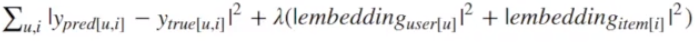

1.以movielens为例，数据格式为user item rating timestamp

In [3]:
import numpy as np 
import pandas as pd

In [9]:
def read_data_and_process(filename, sep='\t'):
    col_names = ['user', 'item', 'rate', 'st']
    df = pd.read_csv(filename, sep=sep, header=None, names=col_names)
    df['user'] -= 1 # 下标从0开始
    df['item'] -= 1
    df['user'].astype(np.int32)
    df['item'].astype(np.int32)
    df['rate'] = df['rate'].astype(np.float32)
    return df

class shuffle_data_iterator(object):
    """
    随机生成一个batch一个batch的数据
    """
    def __init__(self, inputs, batch_size=10):
        self.inputs = inputs
        self.batch_size = batch_size
        self.num_cols = len(self.inputs)
        self.len = len(self.inputs[0])
        self.inputs = np.transpose(np.vstack([np.array(self.inputs[i]) for i in range ]))
        
        # 总样本量
        def __len__(self):
            return self.len
        
        def __iter__(self):
            return self
    
        # 取出下一个batch
        def __next__(self):
            return self.next()
        
        # 随机生成batch_size个下标，取出对应的样本
        def next(self):
            ids = np.random.randint(0, self.len, (self.batch_size,))
            out = self.inputs[ids, :] # 从原始数据抽出对应下标的样本
            return [out[:, i] for i in range(self.num_cols)] 

In [10]:
class one_epoch_data_iterator(shuffle_data_iterator):
    """ 顺序产出一个epoch的数据，在测试中会用到 """
    def __init__(self, inputs, batch_size=10):
        super(one_epoch_data_iterator, self).__init__(inputs, batch_size=batch_size)
        if batch_size > 0:
            self.idx_group = np.array_split(np.arange(self.len), np.ceil(self.len / batch_size))
        else:
            self.idx_group = [np.arange(self.len)]
            
    def next(self):
        if self.group_id >= len(self.idx_group):
            self.group_id = 0
            raise StopIteration
        out = self.inputs[self.idx_group[self.group_id], :]
        self.group_id += 1
        return [out[:, i] for i in range(self.num_cols)]

In [5]:
import numpy as np
np.random.randint(0, 100, (5,))

array([95, 50, 18, 29, 54])

模型搭建

使用tensorflow搭建一个可增量训练的矩阵分解模型，完成基于矩阵分解的推荐系统。